# Using Feature Binning as sample selection

Feature binning is the new coolest tool in the box. Imaging you have to train a Gaussian Processes, or any other kernel method based ML models, and having to deal with a massive dataset. The kernel function is computed pairwise for samples, it means that the **time and space cost of the kernel function is O(n^2)**.

It would cause you headache.

This notebook demonstrate the use of Feature Binning as a way to uniformly subsample the dataset, apply to kernel SVM. You can apply this to other kernel based ML models as well, like GP, or even Kmeans if you fancy. 

The general idea is to put samples into buckets (bins), and use the bucket or the bucket average as the representative value for all of the samples in that bucket. Number of point falls in to that bin could be used as sample weights if the ML implementation supports.

Number of samples will be reduce drastically, from O(n^2) to worst case O(b\*k\*t) where b is the number of bins, k is the number of features, and t is the number of different classes ( if it's classification ) 


However, the binned samples density will be altered for sure. But if you care more about the decision boundary more than the actual density, then this is surely helpful.



In [2]:
%matplotlib inline
from sklearn.datasets import make_moons,make_circles,make_biclusters,make_blobs,make_classification
from sklearn import svm
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
from matplotlib.colors import ListedColormap
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])


## Make a sample dataset

In [80]:
N_SAMPLES = 100000

X, y = make_moons(n_samples=N_SAMPLES,noise=.1)
dataset = pd.DataFrame({'x0':X[:,0],'x1':X[:,1],'y':y})


## Fit a SVM on the original samples

- Notice the sample densities in this case 

/usr/local/lib/python3.5/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


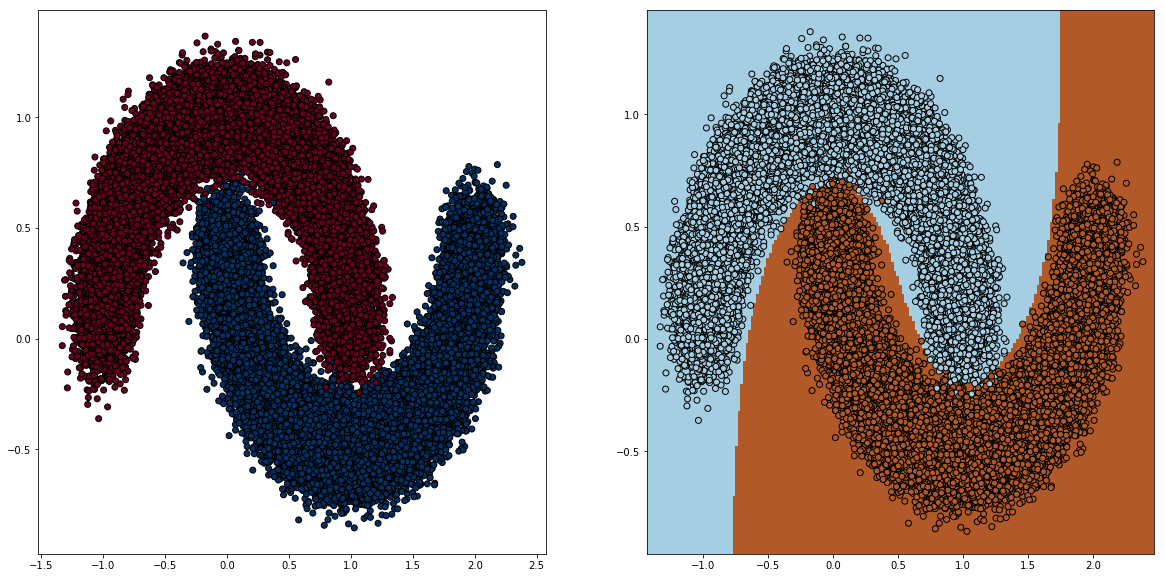

In [81]:


figure = plt.figure(figsize=(20, 10))
ax = plt.subplot(1,2, 1)    
plt.scatter(dataset.x0,dataset.x1, c=dataset.y, cmap=cm,
               edgecolors='k')



clf = svm.SVC(kernel='rbf')
clf.fit(dataset[['x0','x1']],dataset['y'])



meshx0,meshx1 = np.meshgrid(np.arange(dataset.x0.min()-0.1,
                                      dataset.x0.max()+0.1, 0.02),
                            np.arange(dataset.x1.min()-0.1,
                                     dataset.x1.max()+0.1,0.02))

Z = clf.predict(np.c_[meshx0.ravel(), meshx1.ravel()])
Z = Z.reshape(meshx1.shape)
ax = plt.subplot(1,2,2)    

plt.pcolormesh(meshx0, meshx1, Z, cmap=plt.cm.Paired)
plt.scatter(dataset.x0,dataset.x1, c=y, cmap=plt.cm.Paired,
           edgecolors='k')


In [82]:
featbin = KBinsDiscretizer(n_bins=100,
                        strategy='uniform',
                        encode='ordinal')

x_bin = featbin.fit_transform(dataset[['x0','x1']])

#Convert back to the original scale
x_bin = featbin.inverse_transform(x_bin)

dataset['x0_bin'] = x_bin[:,0]
dataset['x1_bin'] = x_bin[:,1]


sample_weights = dataset.groupby(['x0_bin','x1_bin','y'])['y'].count()
sample_weights = sample_weights.rename('count').reset_index()

binarized_dataset = dataset.groupby(['x0_bin','x1_bin','y'])['y'].mean().rename('ycont').reset_index()
binarized_dataset  = pd.merge(left=binarized_dataset,
                              right=sample_weights,
                              on=['x0_bin','x1_bin','y'],how='inner')

binarized_dataset = binarized_dataset[['x0_bin','x1_bin','y','count']]
binarized_dataset.columns = ['x0','x1','y','weight']



## Checkout the magic 

In [83]:
dataset.shape, binarized_dataset.shape

((100000, 5), (4966, 4))

/usr/local/lib/python3.5/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


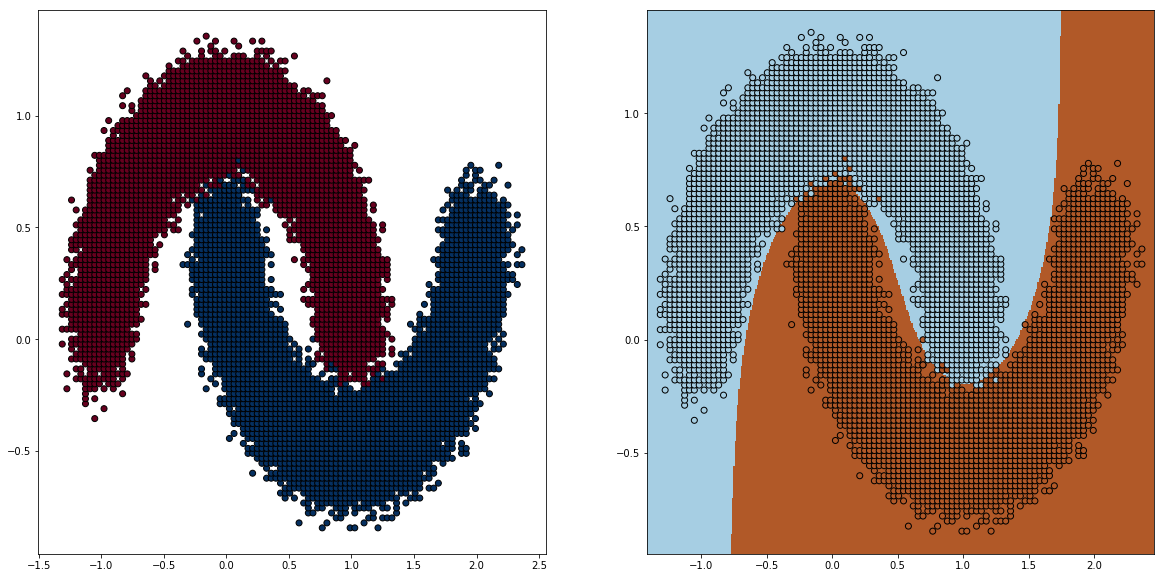

In [84]:

clf = svm.SVC(kernel='rbf')
clf.fit(binarized_dataset[['x0','x1']],
        binarized_dataset['y'],
        sample_weight=binarized_dataset['weight'])

figure = plt.figure(figsize=(20, 10))
ax = plt.subplot(1,2, 1)    
plt.scatter(binarized_dataset.x0,binarized_dataset.x1, c=binarized_dataset.y, cmap=cm,
               edgecolors='k')


meshx0,meshx1 = np.meshgrid(np.arange(binarized_dataset.x0.min()-0.1,
                                      binarized_dataset.x0.max()+0.1, 0.01),
                            np.arange(binarized_dataset.x1.min()-0.1,
                                     binarized_dataset.x1.max()+0.1,0.01))

Z = clf.predict(np.c_[meshx0.ravel(), meshx1.ravel()])
Z = Z.reshape(meshx1.shape)
ax = plt.subplot(1,2, 2)    

plt.pcolormesh(meshx0, meshx1, Z, cmap=plt.cm.Paired)
plt.scatter(binarized_dataset.x0,binarized_dataset.x1,
            c=binarized_dataset.y, cmap=plt.cm.Paired,
            sedgecolors='k')
